In [57]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])
ts["Close_Diff"] = ts["Adj Close"].diff()

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ts.loc[:, ["Adj Close"]].dropna()) # For using stock prices
#training_set_scaled = sc.fit_transform(ts.loc[:, ["Close_Diff"]].dropna()) # For using percentage differences

In [4]:
# Train, test split
series = training_set_scaled
train_size = int(round(len(series) * 0.80, 0))

train_set = series[:train_size]
test_set = series[train_size:]

In [5]:
assert (len(train_set) + len(test_set)) == len(series)

In [6]:
def create_dataset(dataset, look_back = 1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [7]:
LOOK_BACK = 2
X_train, y_train = create_dataset(train_set, LOOK_BACK)
X_test, y_test = create_dataset(test_set, LOOK_BACK)

In [8]:
X_train.shape

(364, 2)

In [9]:
# The LSTM network expects the input data (X) to be provided in the form of: [samples, time steps, features].
# Currently, our data is in the form: [samples, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [10]:
X_train.shape

(364, 1, 2)

In [17]:
def build_model(opt, d):
    model = Sequential()
    model.add(LSTM(4, input_shape = (1, LOOK_BACK), dropout = d)) # , return_sequences = True
    # model.add(LSTM(4, input_shape = (1, LOOK_BACK))) # If more layers are included, the comment from above also needs to be included.
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = 'RootMeanSquaredError')
    return model

In [18]:
param_list = []

opti = ["Adam"] # ["rmsprop", "SGD", "Adam"]
drop = [0, 0.1] # [0, 0.1, 0.2, 0.5]

for opt in opti:
    for d in drop:
        model = build_model(opt, d)
        history = model.fit(X_train, y_train, epochs = 100, batch_size = 1, validation_split = 0.2, verbose = 0)
        param_list.append("Dropout: " + str(0) + 
                                " & Optimizer:" + opt +
                                " ;Train MSE: " + str(history.history['root_mean_squared_error']) + 
                                " ;Train Loss: "+ str(history.history['loss']) + 
                                " ;Val MSE:" + str(history.history['val_root_mean_squared_error']) +
                                " ;Val Loss:" + str(history.history['val_loss'])
                                )

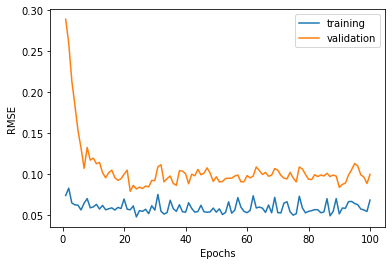

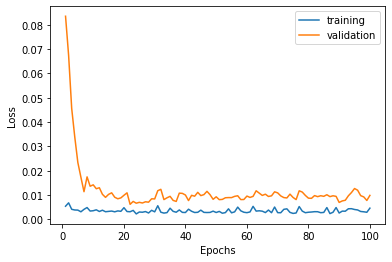

In [20]:
import matplotlib.pyplot as plt

rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [21]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = sc.inverse_transform(model.predict(X_train))
testPredict  = sc.inverse_transform(model.predict(X_test))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))

In [22]:
testScore

172.34875436860278

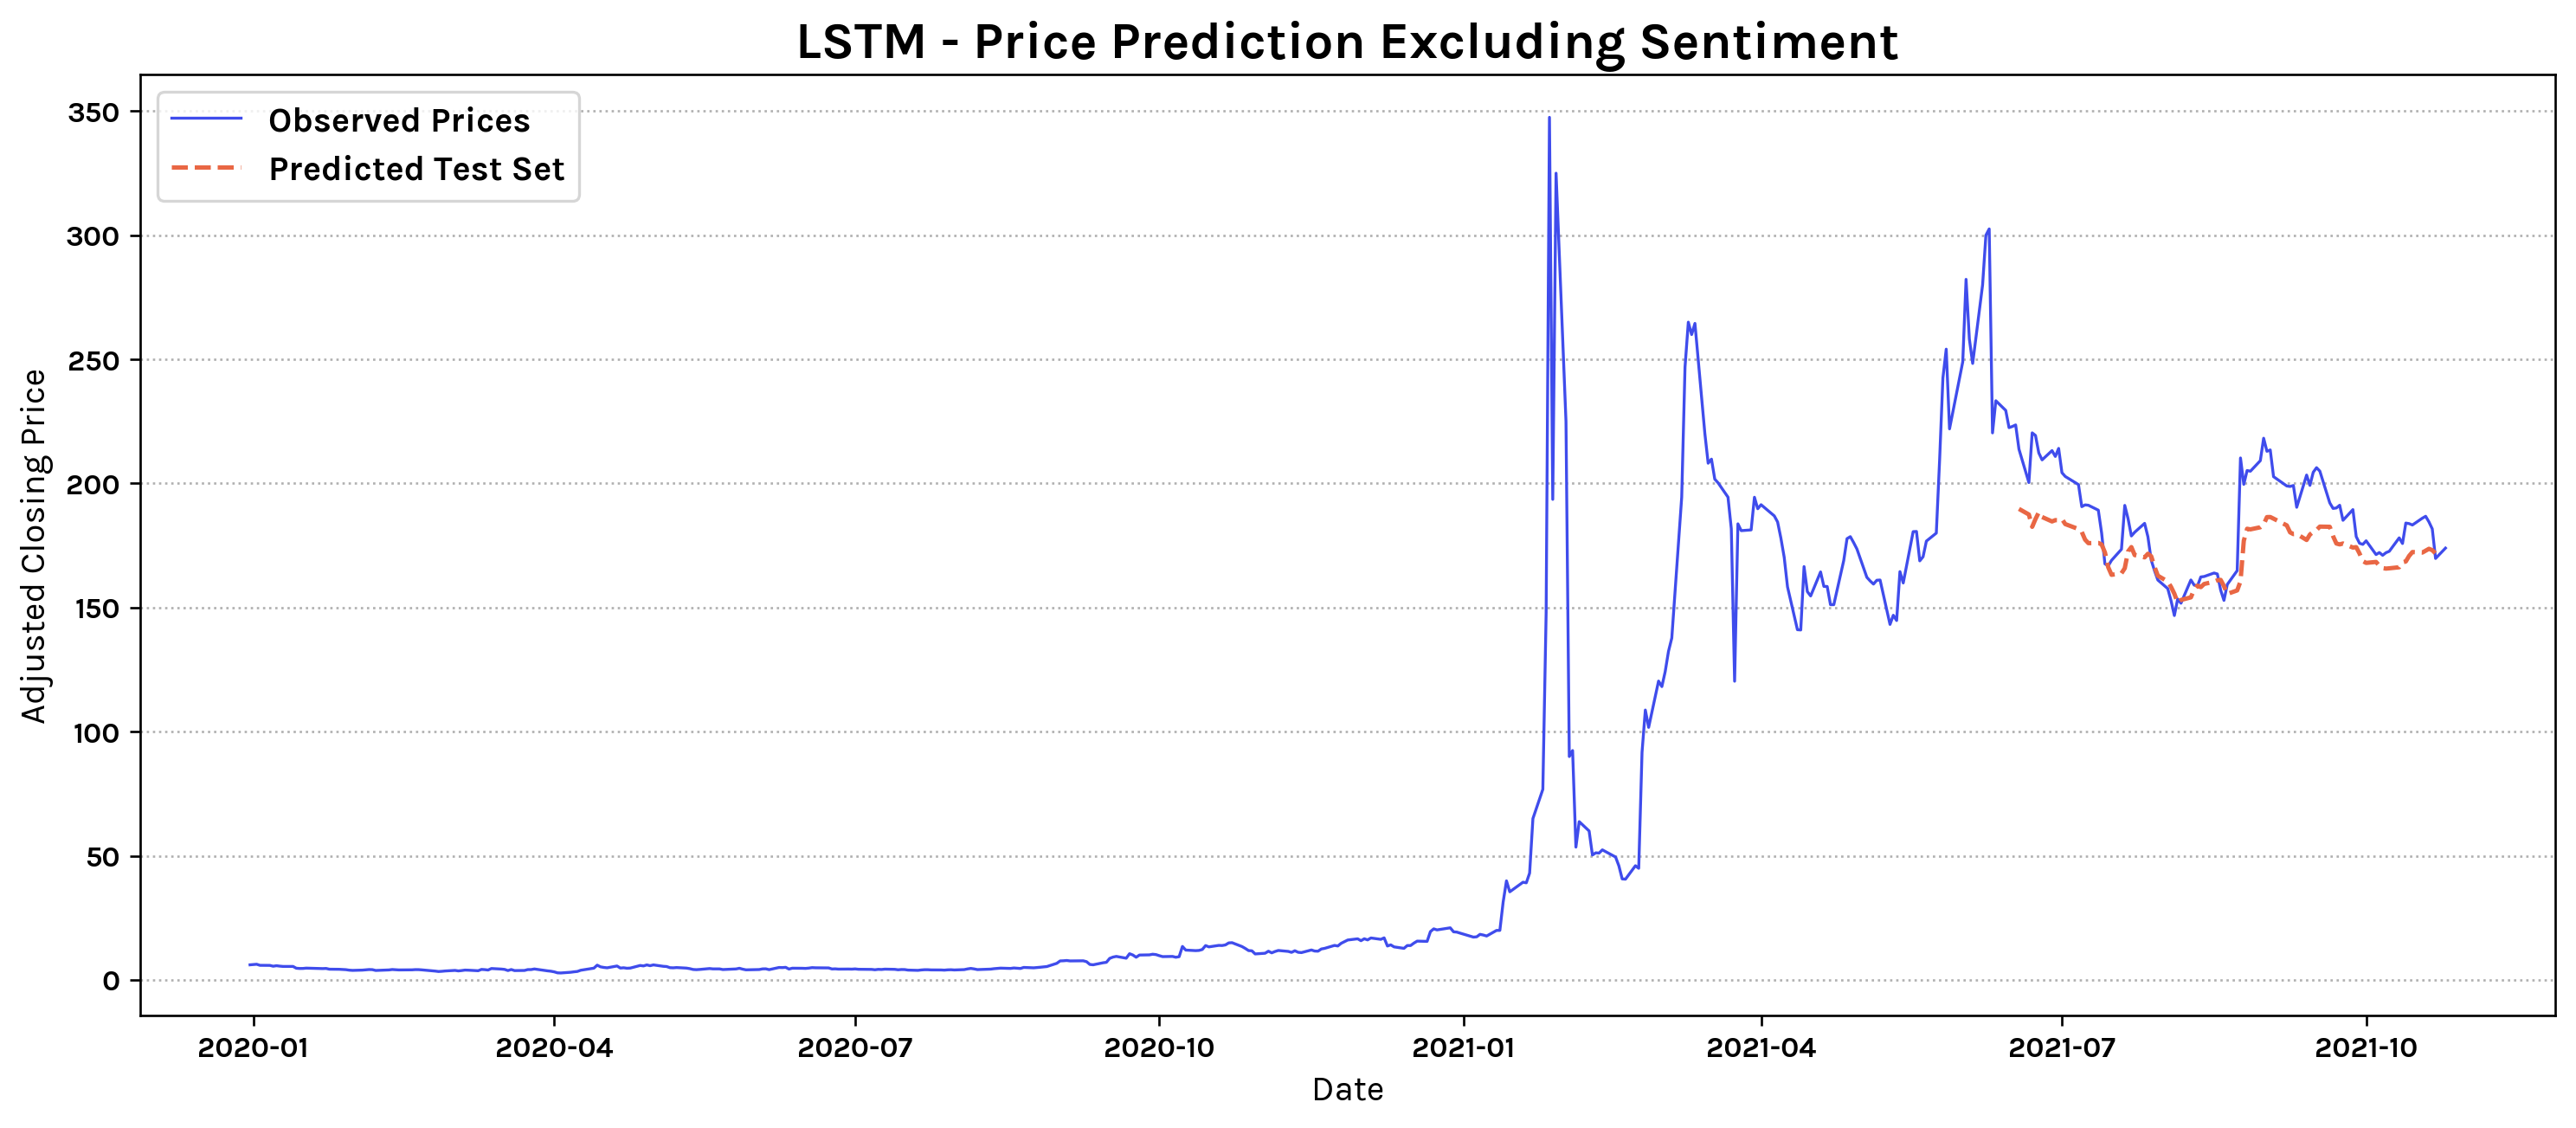

In [23]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(training_set_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(training_set_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(training_set_scaled)-1, :] = testPredict
# plot baseline and predictions

x = ts.Date

plt.plot(x, sc.inverse_transform(training_set_scaled), color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
# plt.plot(x, trainPredictPlot, color = "#FFC322", linestyle='dashed', label = "Predicted Train Set")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 12})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("LSTM - Price Prediction Excluding Sentiment", fontsize = 18, weight = "bold")

plt.show()